In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pycountry
from countryinfo import CountryInfo
from tqdm import tqdm

from mitools import etl
from mitools import pandas as pdf
from mitools import nlp
from mitools import clustering as clustering
from mitools import utils
from mitools.country_converter import cc
import mitools.jupyter_utils

In [2]:
recalculate = True

# Parameters

## Paths

In [3]:
DB_PATH = '/Users/sebastian/Desktop/MontagnaInc/Research/DataWork/Co-Research/Papers_Analysis/Lens Data'
DB_NAME = 'household_emissions_papers.db'
ARTICLES_CSV = os.path.join(DB_PATH, 'household_emissions_articles.csv')
DATA_AND_FIGURES_FOLDER = os.path.join(DB_PATH, 'Data_and_Figures')
if not os.path.exists(DATA_AND_FIGURES_FOLDER):
    os.mkdir(DATA_AND_FIGURES_FOLDER)

## Names

In [4]:
int_cols = ['Publication Year', 'Volume', 'Issue Number', 'Start Page',
            'End Page', 'Citing Patents Count', 'Citing Works Count']
str_cols = ['Lens ID', 'Title', 'Publication Type', 'Source Title', 'ISSNs', 'Publisher', 'Source Country', 'Author/s',
            'Abstract', 'Fields of Study', 'Keywords', 'MeSH Terms', 'Chemicals', 'Funding', 'Source URLs', 'External URL', 'PMID', 'DOI', 'Microsoft Academic ID', 'PMCID', 'References',
           'Open Access License', 'Open Access Colour']
date_cols = ['Date Published']
bool_cols = ['Is Open Access']

In [5]:
csv_file = ARTICLES_CSV
tablename = os.path.basename(csv_file).split('.')[0]
time_col = 'Publication Year'
embeddings_col = 'SPECTER Embeddings'
embeddings_tablename = f'{tablename}_embeddings'
umap_cols = ['SPECTER_UMAP_x', 'SPECTER_UMAP_y']
kmeans_col = 'SPECTER_KMeans_cluster'
agg_col = 'SPECTER_Agglomerative_cluster'
cluster_col = kmeans_col
text_col = 'text'
article_id = 'paper_id'
countries_mentions_file = os.path.join(DB_PATH, 'countries_mentions.parquet')

In [6]:
plots_kwargs = {
    'a': dict(
        s=20, 
        alpha=0.5),
    'b': dict(
        s=7, 
        alpha=0.5),
    'c': dict(
        s=7, 
        alpha=0.5)}

centroids_kwargs = {
    'a': dict(
        marker='o', 
        markersize=30,
        alpha=0.75),
    'b': dict(
        marker='o', 
        markersize=20,
        alpha=0.75),
    'c': dict(
        marker='o', 
        markersize=20,
        alpha=0.75)}

ellipses_kwargs = {
    'a': dict( 
            alpha=1.0, 
            linewidth=2.5,
            linestyle='--'),
    'b': dict( 
            alpha=1.0, 
            linewidth=1.5,
            linestyle='--'),
    'c': dict( 
            alpha=1.0, 
            linewidth=1.5,
            linestyle='--')}

# ETL

In [7]:
db_path = DB_PATH
db_name = DB_NAME
conn = etl.connect_to_sql_db(db_path, db_name)

In [8]:
create_table = not etl.check_if_table(conn, tablename) or recalculate

In [9]:
%%execute $create_table
df = pd.read_csv(csv_file, low_memory=False, index_col=0)

In [10]:
%%execute $create_table
df = pdf.prepare_int_cols(df, int_cols, -1)
df = pdf.prepare_str_cols(df, str_cols)
df = pdf.prepare_date_cols(df, date_cols)
df = pdf.prepare_bool_cols(df, bool_cols)

In [11]:
%%execute $create_table
print('Papers before validating: ', df.shape[0])
df['paper_id'] = df['DOI']
df.loc[df['paper_id'] == 'nan', 'paper_id'] = df.loc[df['paper_id'] == 'nan', 'Lens ID']
df = df.loc[df['Title'] != 'nan'].reset_index(drop=True)
print('Papers after validating Title: ', df.shape[0])
df = df.loc[df['Abstract'] != 'nan'].reset_index(drop=True)
print('Papers after validating Abstract: ', df.shape[0])
df['text'] = df['Title'] + '' + df['Abstract']
df = df.replace('nan', '')
df = df.drop_duplicates()
print('Papers after dropping duplicates: ', df.shape[0])

Papers before validating:  3183
Papers after validating Title:  3183
Papers after validating Abstract:  3183
Papers after dropping duplicates:  3183


In [12]:
%%execute $create_table
df.to_sql(tablename, conn, if_exists='replace')

In [13]:
%%execute not $create_table
df = etl.read_sql_table(conn, tablename)

In [14]:
papers_growth = df.loc[(df[time_col] > 1991), time_col].value_counts().sort_index(ascending=True).to_frame()
df_new = papers_growth.copy()
df_new.index = papers_growth.index 
df_new.index = [f'{i}-{i+2}' for i in df_new.index]
papers_growth = df_new.groupby(df_new.index).sum()
papers_cum = papers_growth.cumsum()

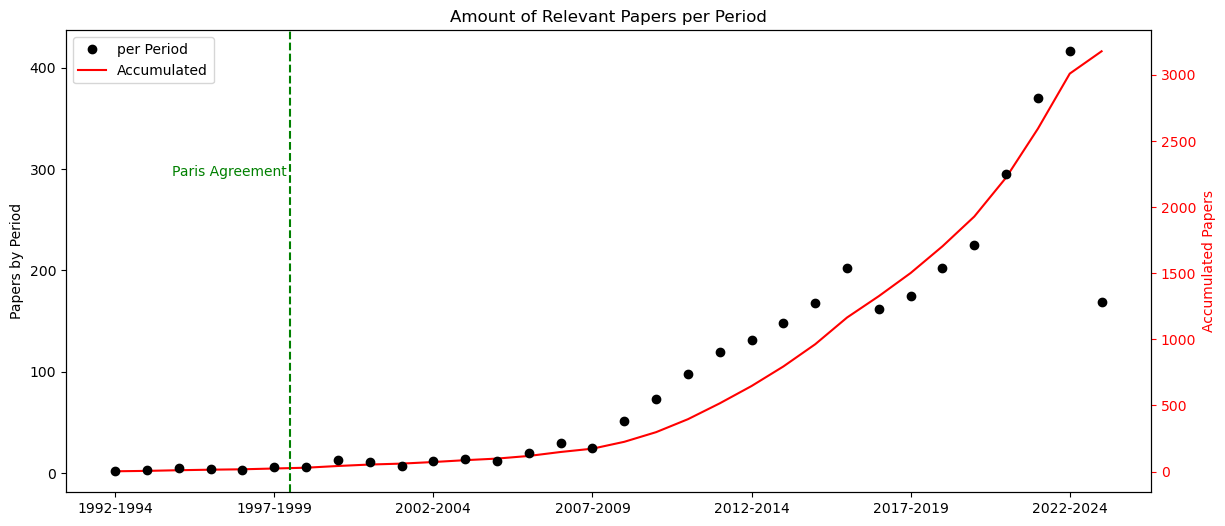

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

ax = papers_growth.plot(
color='k', marker='o', linestyle='', ax=ax)
ax.axvline(5.5, color='g', linestyle='--', zorder=1)
ax.set_title('Amount of Relevant Papers per Period')
ax.text(5.4, 0.695 * plt.ylim()[1], 'Paris Agreement', 
        horizontalalignment='right', 
        verticalalignment='top', 
        color='g')

ax2 = ax.twinx()
papers_growth.cumsum().plot(ax=ax2, color='r', marker='', linestyle='-')
ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='red')

ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

ax.set_ylabel('Papers by Period')
ax2.set_ylabel('Accumulated Papers')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax.legend(lines + lines2, ['per Period'] + ['Accumulated'], loc='upper left')
ax2.grid(False)
ax2.get_legend().remove()

plt.savefig(os.path.join(DATA_AND_FIGURES_FOLDER, 'Total_Growth_by_Time.png'))
plt.show()

## Embeddings

In [16]:
embed = embeddings_col not in df.columns or recalculate

In [17]:
%%execute $embed
df[embeddings_col] = ''
papers = df[text_col].values.tolist()
embeddings = nlp.huggingface_specter_embed_texts(papers, n_threads=6)

Parallelizing!


100%|██████████| 796/796 [05:06<00:00,  2.60it/s]


In [18]:
%%execute $embed
for n, embedding in enumerate(embeddings):
    df.loc[n, embeddings_col] = str(embedding if isinstance(embedding, list) else embeddings.tolist())

In [19]:
%%execute $embed
df.to_sql(tablename, conn, if_exists='replace')

In [20]:
%%execute not $embed
df = etl.read_sql_table(conn, tablename)

## Embeddings Table

In [21]:
create_embeddings = not etl.check_if_table(conn, embeddings_tablename) or recalculate

In [22]:
%%execute $create_embeddings
embeddings = nlp.embeddings_col_to_frame(df[embeddings_col])
embeddings.index.name = 'index'
embeddings.to_sql(embeddings_tablename, conn, if_exists='replace')

In [23]:
%%execute not $create_embeddings
embeddings = etl.read_sql_table(conn, embeddings_tablename)
if any(not utils.str_is_number(c) for c in embeddings.columns):
    label_col = [c for c in embeddings.columns if not utils.str_is_number(c)][0]
    embeddings = embeddings.set_index(label_col, append=True)

## UMAP Embeddings

In [24]:
create_umap = any(col not in df.columns for col in umap_cols) or recalculate

In [25]:
%%execute $create_umap
umap_embeddings = nlp.umap_embeddings(embeddings)
df[umap_cols] = umap_embeddings

In [26]:
%%execute $create_umap
df.to_sql(tablename, conn, if_exists='replace')

In [27]:
%%execute not $create_umap
df = etl.read_sql_table(conn, tablename)

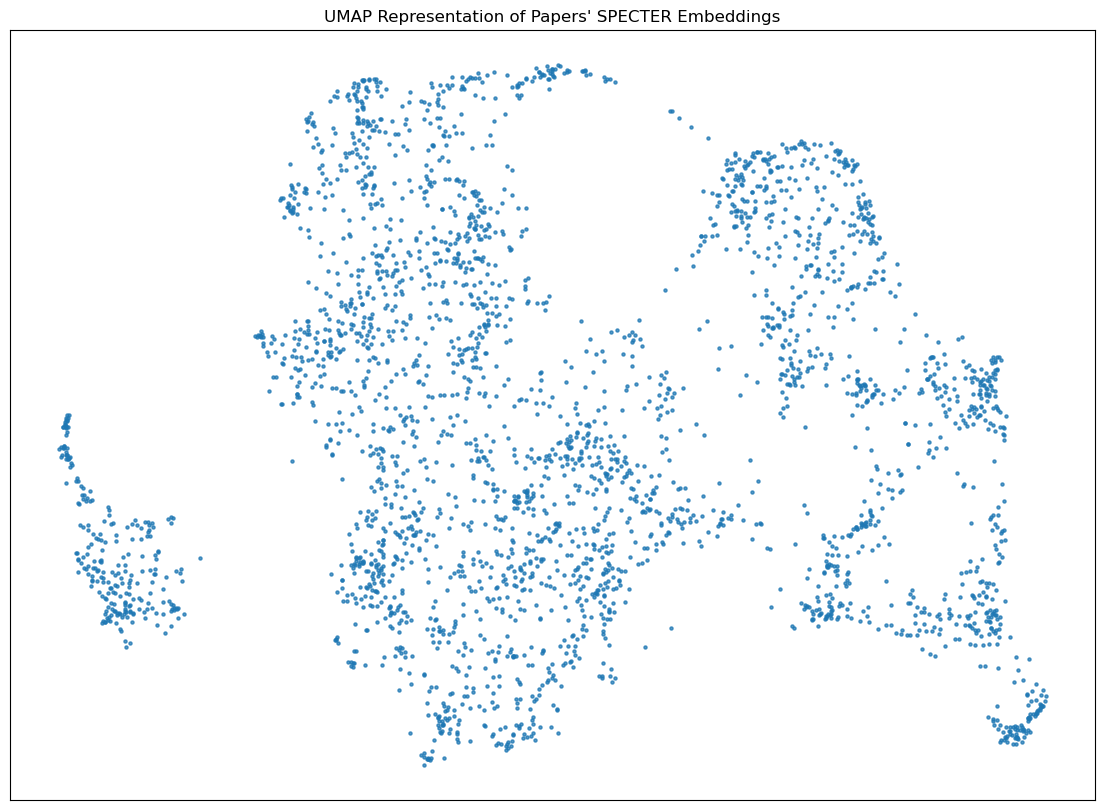

In [28]:
colors = sns.color_palette('Paired', 2)

fig = plt.figure(figsize=(14, 10))
plt.scatter(df[umap_cols[0]], df[umap_cols[1]], s=5, color=colors[1], alpha=0.75)
plt.xticks([])
plt.yticks([])
plt.title("UMAP Representation of Papers' SPECTER Embeddings")

plt.savefig(os.path.join(DATA_AND_FIGURES_FOLDER, 'Umap_Representation_of_Embeddings.png'))
plt.show()

## Clustering 

### K-Means

In [29]:
calculate_kmeans = kmeans_col not in df.columns or recalculate

100%|██████████| 23/23 [00:10<00:00,  2.11it/s]


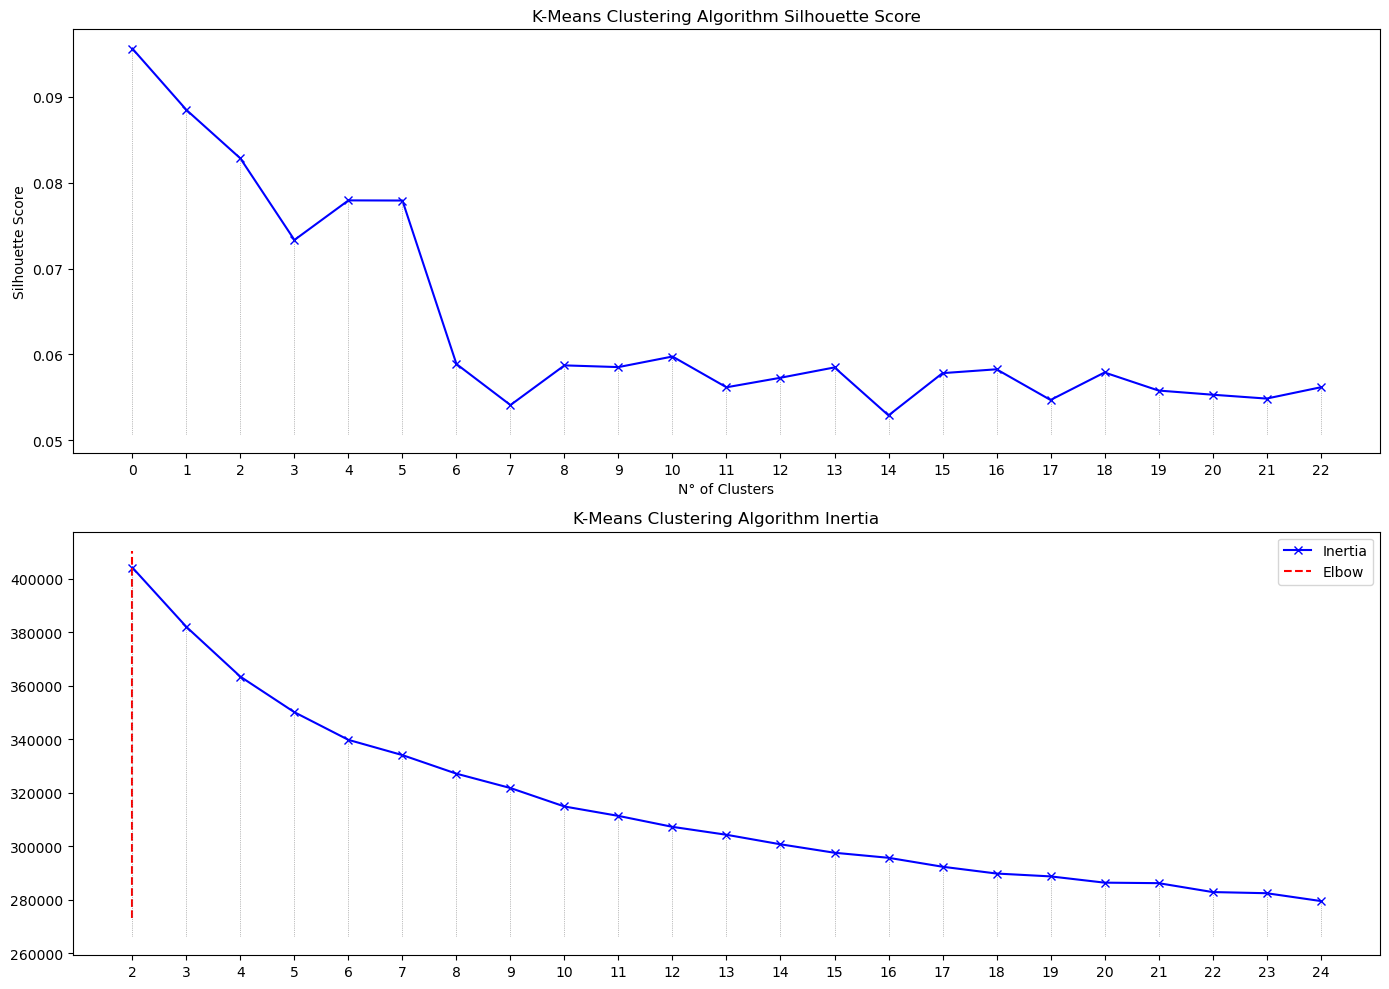

In [30]:
%%execute $calculate_kmeans
silhouette_scores, inertia = clustering.kmeans_ncluster_search(embeddings)
clustering.plot_kmeans_ncluster_search(silhouette_scores, inertia)

In [31]:
%%execute $calculate_kmeans
n_clusters = 13
df[kmeans_col] = clustering.kmeans_clustering(embeddings, n_clusters)
df.to_sql(tablename, conn, if_exists='replace')

In [32]:
%%execute not $calculate_kmeans
df = etl.read_sql_table(conn, tablename)

### Agglomerative

In [33]:
calculate_agg = agg_col not in df.columns or recalculate

100%|██████████| 23/23 [00:34<00:00,  1.52s/it]


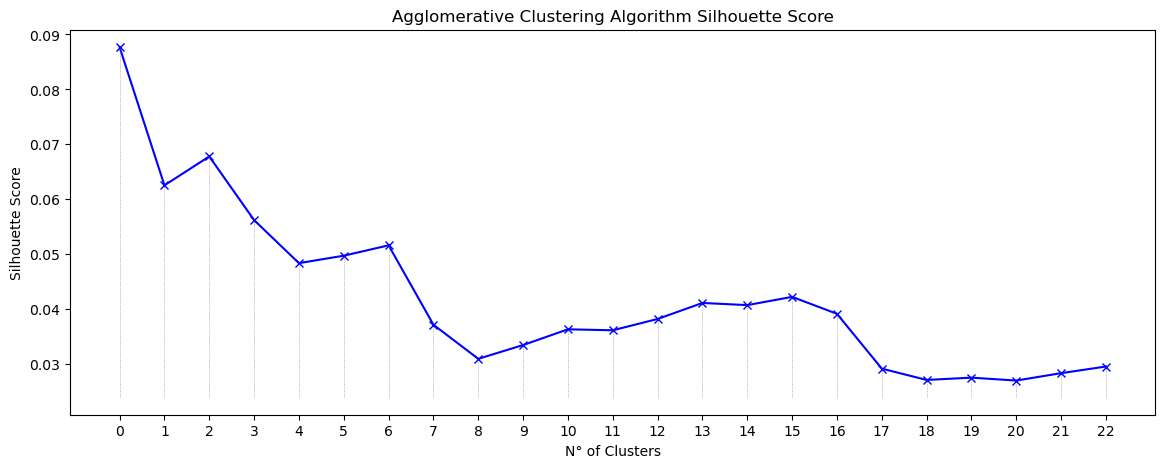

In [34]:
%%execute $calculate_agg
silhouette_scores = clustering.agglomerative_ncluster_search(embeddings)
clustering.plot_agglomerative_ncluster_search(silhouette_scores)

In [35]:
%%execute $calculate_agg
n_clusters = 15
df[agg_col] = clustering.agglomerative_clustering(embeddings, n_clusters)
df.to_sql(tablename, conn, if_exists='replace')

In [36]:
%%execute not $calculate_agg
df = etl.read_sql_table(conn, tablename)

### Cluster Visualization

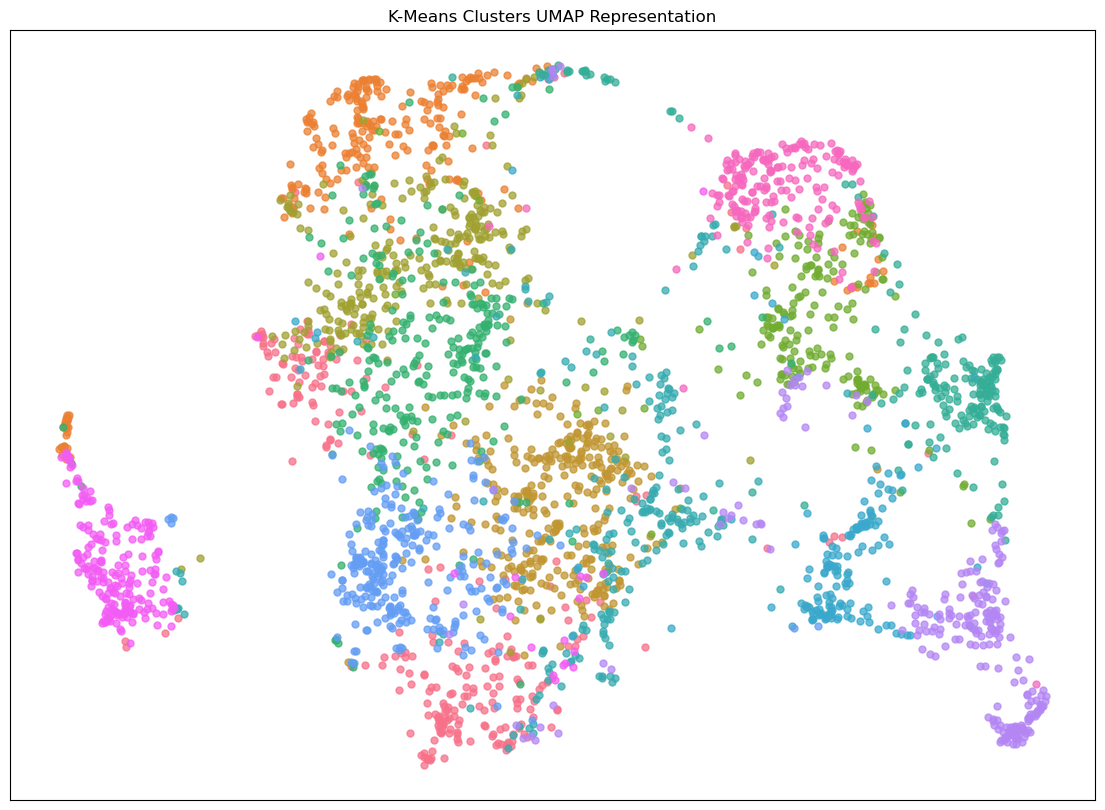

In [37]:
ax = clustering.plot_clusters(df, kmeans_col, *umap_cols, s=100, marker='.', alpha=0.75)
ax.set_title('K-Means Clusters UMAP Representation')
plt.savefig(os.path.join(DATA_AND_FIGURES_FOLDER, f'{kmeans_col}_Clustering.png'))
plt.show()

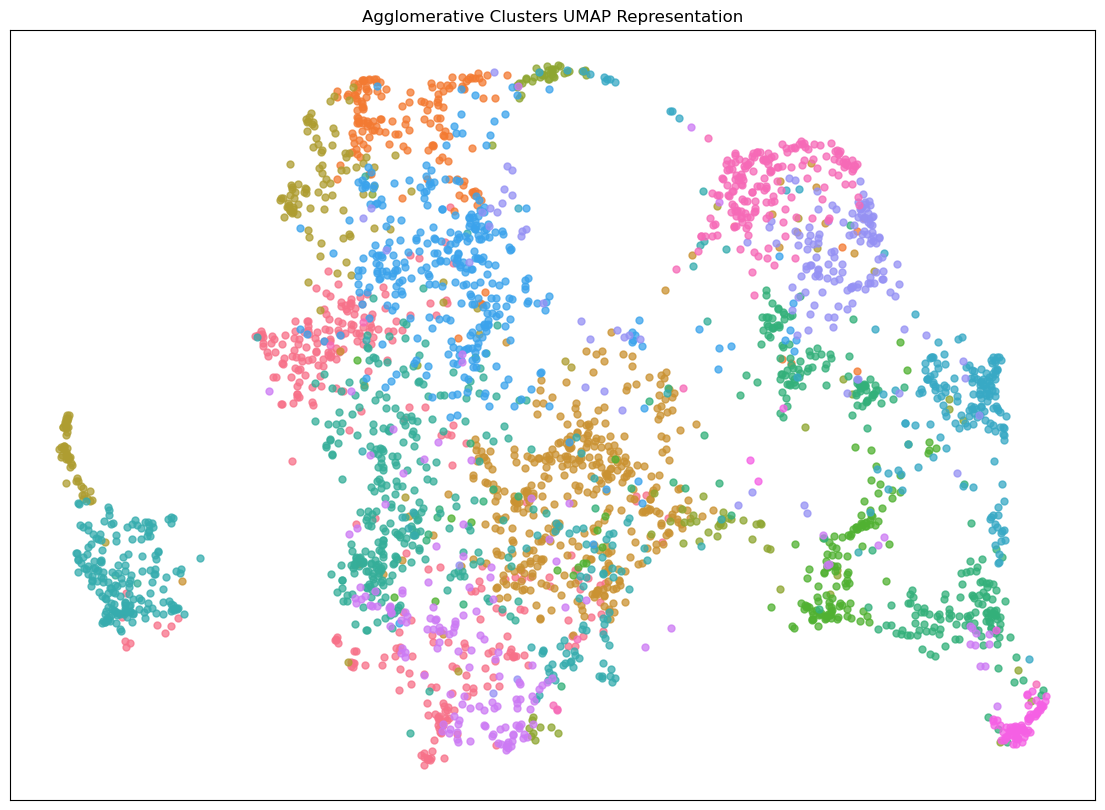

In [38]:
ax = clustering.plot_clusters(df, agg_col, *umap_cols, s=100, marker='.', alpha=0.75)
ax.set_title('Agglomerative Clusters UMAP Representation')
plt.savefig(os.path.join(DATA_AND_FIGURES_FOLDER, f'{agg_col}_Clustering.png'))
plt.show()

### Add Clusters to Embeddings

In [39]:
add_clusters = cluster_col not in embeddings.index.names or recalculate

In [40]:
%%execute $add_clusters
embeddings.index = pd.MultiIndex.from_arrays([embeddings.index.values,
                                             df[cluster_col].values],
                                             names=[embeddings.index.name, cluster_col]
                                            )
embeddings.to_sql(embeddings_tablename, conn, if_exists='replace')

In [41]:
%%execute not $add_clusters
embeddings = etl.read_sql_table(conn, embeddings_tablename)
embeddings = embeddings.set_index(cluster_col, append=True)

### Visualize Clusters

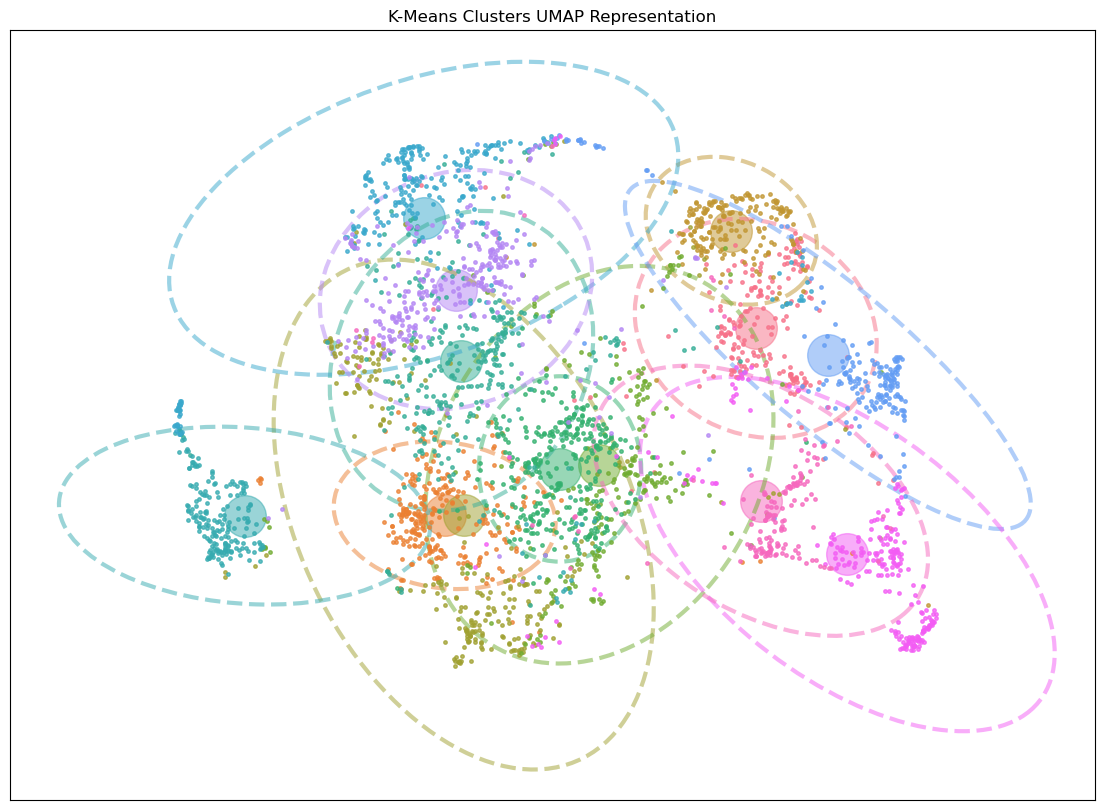

In [42]:
df = df.sort_values(by=cluster_col, ascending=True)
ax = clustering.plot_clusters(df, cluster_col, *umap_cols, marker='.', s=25, alpha=0.75)
umap_centroids = df[[*umap_cols, cluster_col]].groupby(cluster_col).mean().reset_index()
ax = clustering.add_clusters_centroids(ax, umap_centroids, cluster_col, *umap_cols, 
                               marker='o', 
                               markersize=30, 
                               alpha=0.5)
ax = clustering.add_clusters_confidence_ellipse(ax, df, cluster_col, *umap_cols, 
                                        alpha=0.5, 
                                        linewidth=3,
                                        linestyle='--')
ax.set_title('K-Means Clusters UMAP Representation')
plt.savefig(os.path.join(DATA_AND_FIGURES_FOLDER, 'Clusters_with_Centroids_and_Confidence_Ellipses.png'))
plt.show();

### Cluster Analysis

#### Count

In [43]:
clustering.display_clusters_size(df, cluster_col)

,N Elements
SPECTER_KMeans_cluster,
0,201
1,272
2,197
3,279
4,222
5,336
6,299
7,213
8,260


#### Growth Rate

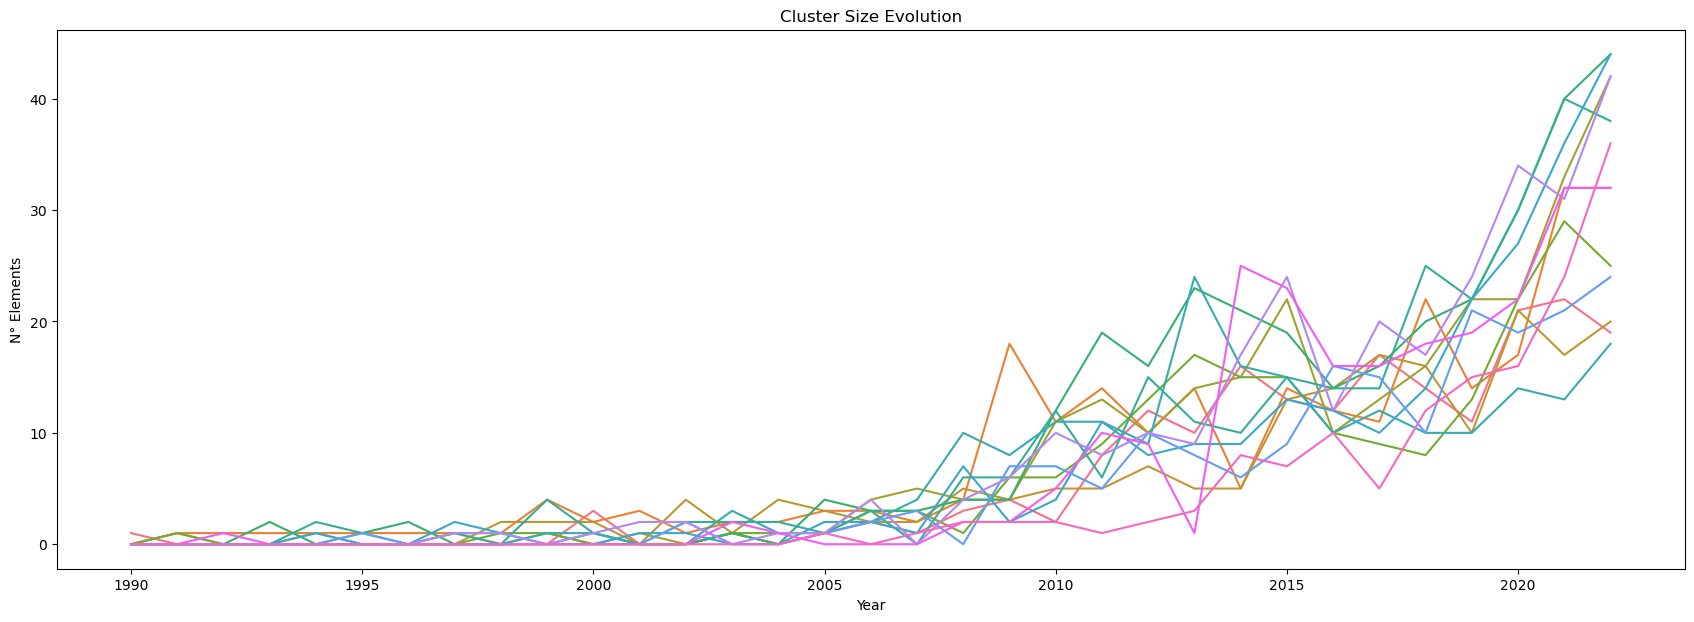

In [44]:
clustering.plot_clusters_growth(df, time_col, cluster_col)
plt.savefig(os.path.join(DATA_AND_FIGURES_FOLDER, 'Total_Growth_by_Time_per_Cluster.png'))
plt.show()

#### Cosine Similarities

In [45]:
cosine_similarities = clustering.get_cosine_similarities(embeddings, cluster_col)

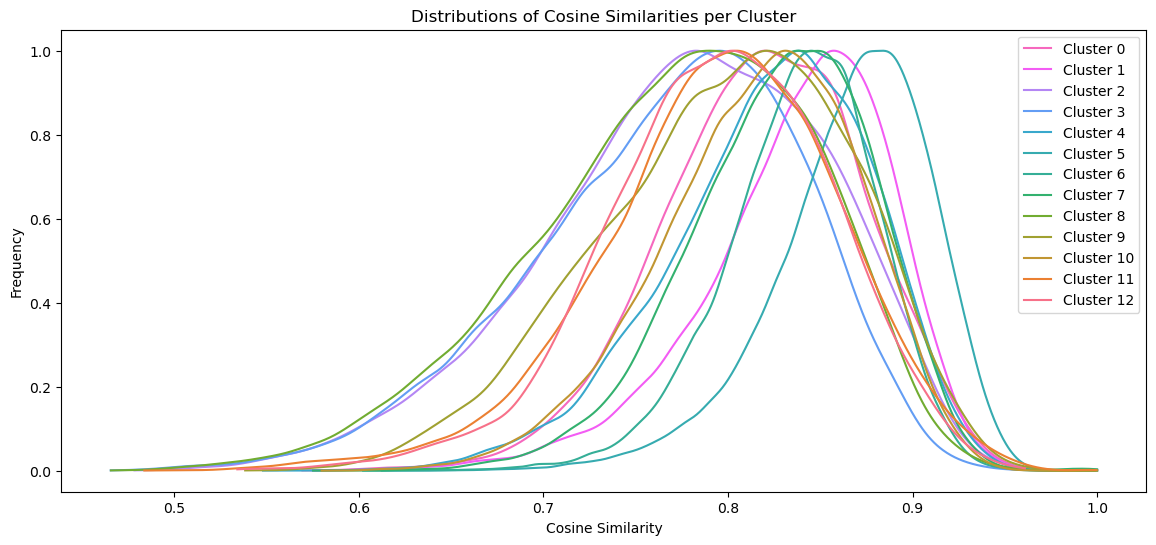

In [46]:
clustering.plot_cosine_similarities(cosine_similarities, normed=True)
plt.savefig(os.path.join(DATA_AND_FIGURES_FOLDER, 'Cosine_Similarities_Distribution_per_Cluster.png'))
plt.show()

#### Centroids

In [47]:
centroids = clustering.get_clusters_centroids(embeddings, cluster_col)

##### Distances Between Centroids

In [48]:
centroids_distances = clustering.get_clusters_centroids_distances(centroids)

In [49]:
centroids_distances

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,4.768372e-07,1.123618e+01,8.234425e+00,10.116409,9.038627,9.114396,8.650721e+00,1.232799e+01,9.686766e+00,7.117668,8.044297,9.293976e+00,8.804890
1,1.123618e+01,5.840039e-07,1.221488e+01,8.173972,8.032511,5.917465,6.242208e+00,9.627638e+00,1.213699e+01,13.243126,9.563237,1.057905e+01,11.099083
2,8.234425e+00,1.221488e+01,3.371748e-07,9.952655,8.330078,10.397523,1.122284e+01,1.151614e+01,1.067690e+01,8.507995,8.972877,1.172947e+01,10.660934
3,1.011641e+01,8.173972e+00,9.952655e+00,0.000000,7.485962,8.233677,7.722407e+00,8.686089e+00,1.074191e+01,11.729021,7.009857,9.698693e+00,7.595996
4,9.038627e+00,8.032511e+00,8.330078e+00,7.485962,0.000000,5.570525,7.874246e+00,7.846263e+00,1.092939e+01,9.986173,7.162989,8.593827e+00,9.849736
5,9.114396e+00,5.917465e+00,1.039752e+01,8.233677,5.570525,0.000000,6.482076e+00,9.000225e+00,1.158567e+01,11.356422,7.938815,1.004093e+01,9.743470
6,8.650721e+00,6.242208e+00,1.122284e+01,7.722407,7.874246,6.482076,8.259062e-07,9.350757e+00,7.550451e+00,11.234883,5.799437,1.086908e+01,10.212482
7,1.232799e+01,9.627638e+00,1.151614e+01,8.686089,7.846263,9.000225,9.350757e+00,3.371748e-07,1.208636e+01,13.610703,9.227172,1.294912e+01,11.763055
8,9.686766e+00,1.213699e+01,1.067690e+01,10.741909,10.929385,11.585666,7.550451e+00,1.208636e+01,8.259062e-07,10.544645,6.902392,1.361364e+01,12.315035
9,7.117668e+00,1.324313e+01,8.507995e+00,11.729021,9.986173,11.356422,1.123488e+01,1.361070e+01,1.054465e+01,0.000000,9.995238,1.042953e+01,9.556465


#### Distances to Centroid

In [50]:
distances_to_centroids = clustering.get_distances_to_centroids(embeddings, centroids, cluster_col)

In [51]:
distances_to_centroids

,0
SPECTER_KMeans_cluster,
0,7.110306
0,9.532813
0,8.418891
0,10.879110
0,11.388841
...,...
12,11.028302
12,10.690333
12,9.340028


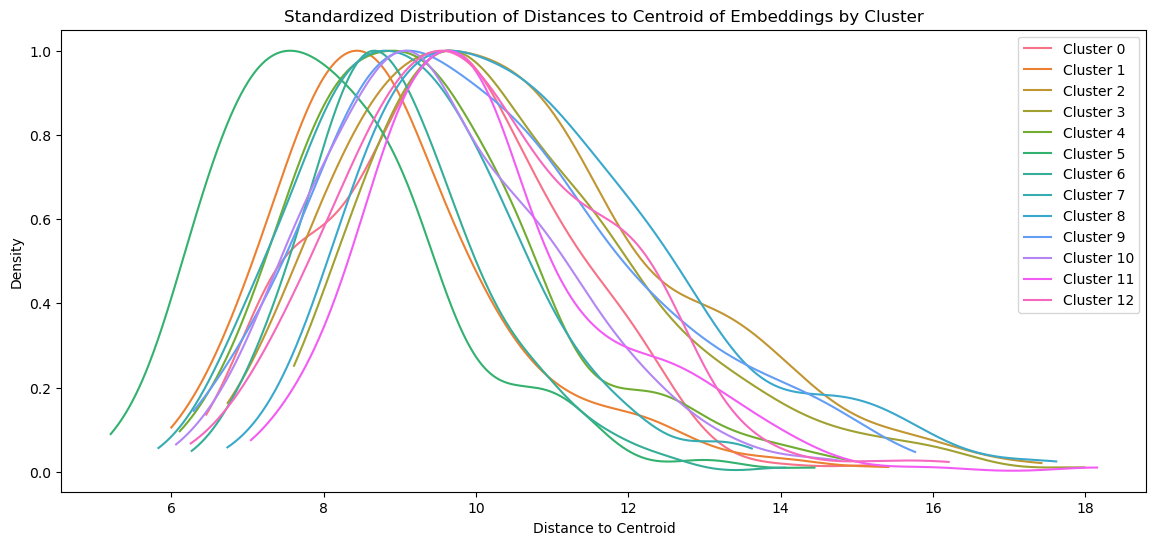

In [52]:
clustering.plot_distances_to_centroids(distances_to_centroids, cluster_col)
plt.savefig(os.path.join(DATA_AND_FIGURES_FOLDER, 'Distances_to_Centroid_Distribution_per_Cluster.png'))
plt.show()

## Keyword Analysis 

In [53]:
all_words = []
for l in df[text_col].str.split(' ').values:
    all_words.extend(l)
all_words = utils.split_strings(all_words)
all_words_str = " ".join(all_words)

In [54]:
freq_splits = nlp.FreqDist(all_words)

In [55]:
tokenizer = nlp.RegexpTokenizer("[A-Za-z]{2,}[0-9]{,1}")
tokens = tokenizer.tokenize(all_words_str)
tokens_norm = nlp.lemmatize_tokens(tokens)

In [56]:
print(f"Number of tokens: {len(tokens)}")
print(f"Number of unique tokens: {len(set(tokens))}")
print(f"Number of unique lemmatized tokens: {len(set(tokens_norm))}")

Number of tokens: 983424
Number of unique tokens: 37034
Number of unique lemmatized tokens: 26834


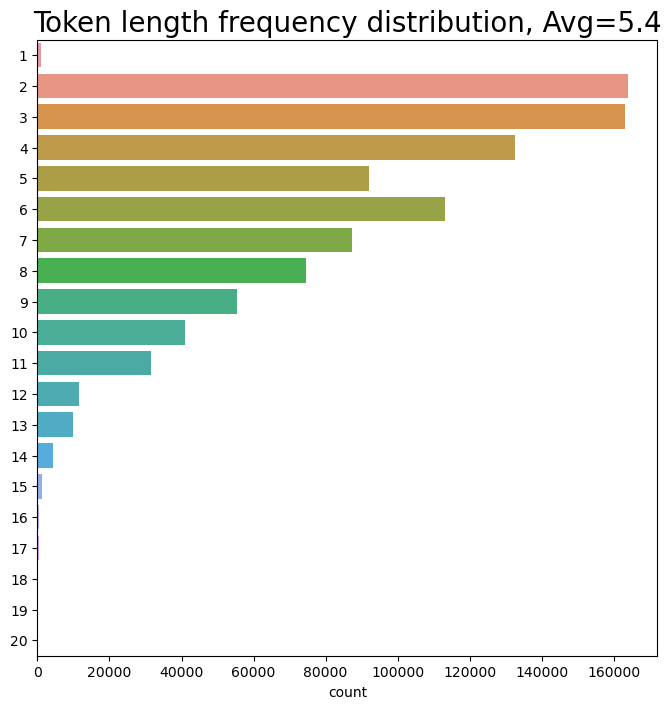

In [57]:
token_length = [len(t) for t in tokens_norm if len(t) < 21]
plt.figure(figsize=(8, 8))
sns.countplot(y=token_length)
plt.title(f"Token length frequency distribution, Avg={round(np.mean(token_length),2)}", size=20)
plt.savefig(os.path.join(DATA_AND_FIGURES_FOLDER, 'Token_Length_Frequency_in_Corpus.png'))
plt.show()

### Stopwords Removal

In [58]:
stop_words = nlp.stopwords.words('english')
stop_words.extend(['the', "mayn", "br", "jats", "https", "title", "abstract", 'google', 'scholar', 
                   'abstracttext', 'sub', 'doi', 'org', 'et', 'al', 'text', 'pdf', 'the',
                  'full', 'fw', 'pm', 'also', 'per', 'jat', 'sec', 'van', 'die', 'ho', 'le', 'ya', 'ka',
                  'und', 'bc', 'oc', 'may', 'jul', 'jun', 'thu', 'http', 'de', 'la', 'tsa', 'di', 'en', 'se', 'tse',
                  'wa', 'na', 'der', 'theko', 'ha', 'tot', 'cdm'])

In [59]:
freq_stopwords = [(sw, tokens_norm.count(sw)) for sw in stop_words]
freq_stopwords.sort(key=lambda x: x[1], reverse=True)

n_stopwords = len([t for t in tokens_norm if t.lower() in stop_words])
print(f"{n_stopwords} tokens are stop words. A {round(100*n_stopwords/len(tokens_norm),2)}%.")

360504 tokens are stop words. A 36.66%.


### Overview Without Stopwords 

In [60]:
df["N° Sentences"] = df[text_col].apply(nlp.sent_tokenize).apply(len)
df["Tokens"] = df[text_col].apply(tokenizer.tokenize)
df["N° Tokens"] = df["Tokens"].apply(len)
df["N° Characters"] = df[text_col].apply(len)
df["N° Stopwords"] = df["Tokens"].apply(lambda tokens: len([t for t in tokens if t.lower() in stop_words]))
df["% Stopwords"] = df["N° Stopwords"]/df["N° Tokens"]

columns = [cluster_col, 'N° Sentences', 'N° Tokens', 'N° Characters', 'N° Stopwords', '% Stopwords']
print('MEAN STATS')
display(df[columns].groupby(columns[0])[columns[1:]].mean())
print('STD STATS')
display(df[columns].groupby(columns[0])[columns[1:]].std())
print('MIN STATS')
display(df[columns].groupby(columns[0])[columns[1:]].min())
print('MAX STATS')
display(df[columns].groupby(columns[0])[columns[1:]].max())

MEAN STATS


,N° Sentences,N° Tokens,N° Characters,N° Stopwords,% Stopwords
SPECTER_KMeans_cluster,,,,,
0,9.437811,240.800995,1653.696517,86.631841,0.357926
1,10.705882,270.897059,1891.077206,98.783088,0.361469
2,11.913706,290.131980,2035.299492,102.507614,0.354625
3,21.329749,511.655914,3635.555556,184.838710,0.354474
4,11.058559,298.139640,2083.459459,106.162162,0.353571
5,7.633929,216.604167,1526.711310,77.068452,0.353479
6,10.819398,293.936455,2027.160535,108.090301,0.361485
7,8.934272,226.990610,1581.572770,79.516432,0.346037
8,12.292308,282.638462,1973.011538,99.342308,0.356169


STD STATS


,N° Sentences,N° Tokens,N° Characters,N° Stopwords,% Stopwords
SPECTER_KMeans_cluster,,,,,
0,4.824662,92.280443,624.129668,37.624245,0.044009
1,18.700837,447.406149,3235.944820,170.229563,0.043554
2,17.023923,303.033579,2168.974482,102.227019,0.042153
3,41.590054,902.559839,6400.802807,332.734873,0.048530
4,17.031544,385.733671,2629.793944,137.815080,0.045709
5,4.149437,84.159734,589.721019,31.723687,0.041318
6,14.024936,386.017586,2668.516627,149.081805,0.037024
7,5.727738,117.950381,803.432078,45.197533,0.040414
8,22.821092,275.623659,2213.212212,79.017483,0.042317


MIN STATS


,N° Sentences,N° Tokens,N° Characters,N° Stopwords,% Stopwords
SPECTER_KMeans_cluster,,,,,
0,1,31,222,10,0.188811
1,1,35,259,8,0.228571
2,1,32,214,14,0.216162
3,1,33,290,8,0.176136
4,1,39,295,11,0.194836
5,1,19,175,5,0.184615
6,1,38,304,11,0.236735
7,1,38,283,10,0.233333
8,1,48,319,14,0.224825


MAX STATS


,N° Sentences,N° Tokens,N° Characters,N° Stopwords,% Stopwords
SPECTER_KMeans_cluster,,,,,
0,34,747,4979,293,0.487633
1,201,4610,31835,1849,0.508772
2,233,4059,29078,1342,0.473684
3,283,6117,43131,2427,0.466368
4,191,3870,26451,1352,0.531915
5,32,608,4206,201,0.474194
6,213,4698,32145,1785,0.469512
7,56,1290,8780,476,0.471831
8,293,2821,25085,739,0.461756


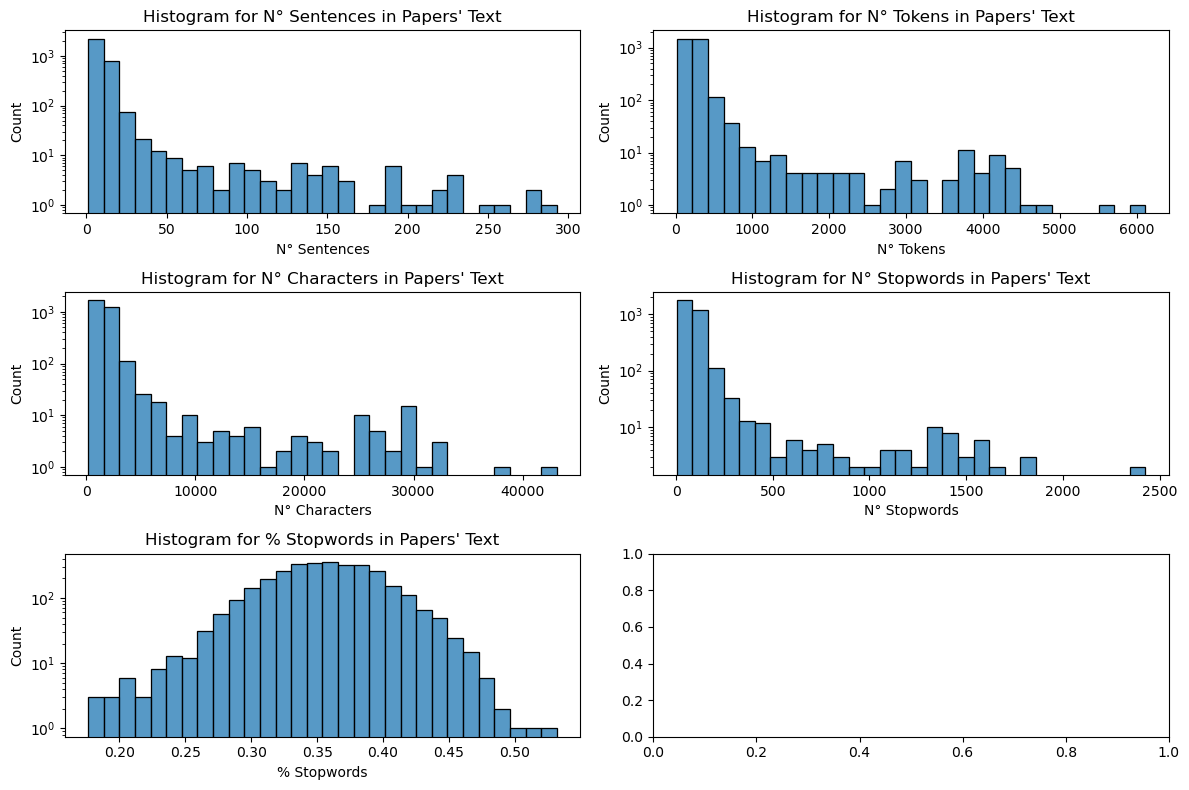

<Figure size 640x480 with 0 Axes>

In [61]:
nlp.plot_token_features(df, columns[1:], hue=None, log=True)
plt.savefig(os.path.join(DATA_AND_FIGURES_FOLDER, 'Token_Features_in_Corpus.png'))
plt.show()

## Paper's Tokens 

In [62]:
papers_tokens = {row[article_id]: nlp.preprocess_text(row[text_col], stop_words) for _, row in df[[article_id, text_col]].iterrows()}
papers_bows = {paper_id: nlp.get_bow_of_text(tokens) for paper_id, tokens in papers_tokens.items()}
papers_frequencies = {paper_id: {w: 100*c/len(bows) for w, c in bows.items()} for paper_id, bows in papers_bows.items()}

## Countries Mentions

In [63]:
create_countries_mentions = not os.path.exists(countries_mentions_file) or recalculate

In [64]:
%%execute $create_countries_mentions
countries = [nlp.preprocess_country_name(cc.convert(country.name, to='name_short')) for country in pycountry.countries]

In [65]:
%%execute $create_countries_mentions
unused_countries = [
    'french southern territories',
    'british indian ocean territory',
    'st kitts and nevis',
    'svalbard and jan mayen islands',
    'united states minor outlying islands',
    'british virgin islands',
    'united states virgin islands',
    'reunion',
    'macau',
    'hong kong',
    'mayotte',
    'martinique'
]
countries = [c for c in countries if c not in unused_countries]
countries.sort()

In [66]:
%%execute $create_countries_mentions 
demonyms = {}
for country in countries:
    try:
        dem = CountryInfo(country).demonym()
        demonyms[dem.lower()] = country
    except Exception:
        pass

In [67]:
%%execute $create_countries_mentions
papers_tokens_df = pd.concat({key: pd.Series(value) for key, value in papers_tokens.items()}, axis=1)
papers_tokens_df.to_csv(os.path.join(DATA_AND_FIGURES_FOLDER, 'Tokens_by_Paper.csv'))

In [ ]:
%%execute $create_countries_mentions
countries_in_papers = {}
for paper_id, _df in tqdm(papers_tokens_df.items()):
    if paper_id not in countries_in_papers:
        countries_in_papers[paper_id] = _df.apply(lambda x: nlp.find_countries_in_paper(x, countries, demonyms))

In [ ]:
%%execute $create_countries_mentions
countries_mentions = []
for paper, c in countries_in_papers.items():
    c.columns = [paper]
    countries_mentions.append(c)
countries_mentions = pd.concat(countries_mentions, axis=1)

In [ ]:
%%execute $create_countries_mentions
frames = []

for col in countries_mentions.columns:
    if not countries_mentions[col].isna().all() and isinstance(countries_mentions[col].dropna().iloc[0], tuple):
        s1 = countries_mentions[col].str[0]
        s2 = countries_mentions[col].str[1]
        temp_df = pd.DataFrame({(col, 'country'): s1, (col, 'found_token'): s2})
        frames.append(temp_df)
    else:
        temp_df = pd.DataFrame({(col, 'country'): np.nan, (col, 'found_token'): np.nan}, index=countries_mentions.index)
        frames.append(temp_df)
countries_mentions = pd.concat(frames, axis=1)

In [ ]:
%%execute $create_countries_mentions
countries_mentions.to_parquet(countries_mentions_file)

In [ ]:
%%execute not $create_countries_mentions
countries_mentions = pd.read_parquet(countries_mentions_file)

### Visualize Countries Mentions

In [ ]:
years = np.sort(df[time_col].unique())
yearly_mentions = []
for year in years:
    year_papers = df.loc[df[time_col] == year, article_id].values
    year_countries_mentions = countries_mentions[year_papers].loc[:, pd.IndexSlice[:,'country']].melt()
    year_countries_mentions = year_countries_mentions.drop_duplicates()
    year_countries_mentions = year_countries_mentions.dropna()
    year_countries_mentions = year_countries_mentions[['value']].value_counts().to_frame()
    year_countries_mentions.columns = [year]
    year_countries_mentions.index.names = ['country']
    yearly_mentions.append(year_countries_mentions)
yearly_mentions = pd.concat(yearly_mentions, axis=1).fillna(0).T

In [ ]:
n = 10
top_n_countries = yearly_mentions.sum(axis=0).sort_values(ascending=False).head(n).index
mentions_to_plot = yearly_mentions.loc[:, top_n_countries]
df_new = mentions_to_plot.copy()
df_new.index = mentions_to_plot.index
df_new.index = [f'{i}-{i+1}' for i in df_new.index]
mentions_to_plot = mentions_to_plot.groupby(df_new.index).sum()
mentions_to_plot.columns = [c[0].title() for c in mentions_to_plot.columns]

In [ ]:
color = sns.color_palette('Paired')
ax = mentions_to_plot.plot(figsize=(21,7), color=color)
ax.axvline(5.5, color='g', linestyle='--', zorder=1)
ax.text(5.4, 0.925 * plt.ylim()[1], 'Paris Agreement', 
        horizontalalignment='right', 
        verticalalignment='top', 
        color='g')

ax.set_title('Amount of Papers that Mention Each Country by Period')
_ = ax.set_ylabel("N° Papers' Mentions")
plt.savefig(os.path.join(DATA_AND_FIGURES_FOLDER, 'Mentions_in_Articles_by_Paper.png'))
plt.show()

## Cluster's Keywords

In [ ]:
clusters = {}
for cl in df[cluster_col].unique():
    cl_papers = df.loc[df[cluster_col] == cl, article_id].values
    clusters[cl] = pd.DataFrame({paper_id: papers_frequencies[paper_id] for paper_id in cl_papers}).fillna(0)

In [ ]:
bows = nlp.get_dataframe_bow(df, text_col, True, stop_words, True)
bows.index = pd.MultiIndex.from_frame(df[[article_id, cluster_col]])
tfidf = nlp.get_tfidf(bows)

In [ ]:
agg_functions = ["mean", "median", "std", "max", "min"]
clusters_stats = bows.groupby(cluster_col).agg(agg_functions)
clusters_stats = (clusters_stats.stack(level=0)
                              .unstack(level=0)
                              .swaplevel(1, 0, axis=1)
                              .sort_index(axis=1, level=[0])
                )

In [ ]:
words_by_cluster = []
for cl, g in clusters_stats.groupby(level=0, axis=1):
    g = g.copy(deep=True)
    g.index.names = [(cl, 'word')]
    words_by_cluster.append(g.reset_index().reset_index(drop=True))
words_by_cluster = pd.concat(words_by_cluster, axis=1)
words_by_cluster = nlp.sort_multiindex_dataframe(words_by_cluster, ['word', 'mean'], 'mean')

In [ ]:
words_by_cluster

In [ ]:
percentage = 1.5
n = int(clusters_stats.shape[0] * (percentage / 100))
top_means = clusters_stats.xs(key='mean', axis=1, level=1).apply(lambda x: x.nlargest(n).index, axis=0)
clusters_bows = top_means.to_dict()
clusters_bows = {k: list(v.values()) for k, v in clusters_bows.items()}
common_bow = set(clusters_bows[list(clusters_bows.keys())[0]])  # Start with the first cluster's BOW
for bow in clusters_bows.values():
    common_bow = common_bow.intersection(bow)
len(common_bow)

In [ ]:
selected_cols = ['word', 'mean']
unique_words_by_cluster = []
for cl in words_by_cluster.columns.get_level_values(0).unique():
    words = words_by_cluster.loc[:, [(cl, col) for col in selected_cols]]
    words = words.loc[~words[(cl, 'word')].isin(common_bow)].reset_index(drop=True)
    unique_words_by_cluster.append(words)
unique_words_by_cluster = pd.concat(unique_words_by_cluster, axis=1)

In [ ]:
unique_words_by_cluster

## Clusters Names

In [ ]:
print('Removed Words:')
', '.join(word.title() for word in common_bow)

In [ ]:
selected_cols = ['word', 'mean']
words_amount = 7
cluster_names = {}
for cl in unique_words_by_cluster.columns.get_level_values(0).unique():
    words = (unique_words_by_cluster.loc[:, [(cl, col) for col in selected_cols]]
             .nlargest(words_amount, columns=[(cl, 'mean')])
             [(cl, 'word')].values)
    name = ', '.join(word.title() for word in list(words))
    cluster_names[cl] = name

for k, v in cluster_names.items():
    print(f'Cluster {k}: {v}')

In [ ]:
cluster_names_col = f'{cluster_col} names'
df[cluster_names_col] = df[cluster_col].map(cluster_names)
df = df.sort_values(cluster_col, ascending=True)

In [ ]:
axes = clustering.plot_clusters_evolution(df.sort_values(cluster_col, ascending=True), cluster_names_col, *umap_cols, time_col, (1987, 2016),
                                          plots_kwargs=plots_kwargs)
for ax in axes:
    umap_centroids = df[[*umap_cols, cluster_col]].groupby(cluster_col).mean().reset_index()
    axes[ax] = clustering.add_clusters_centroids(axes[ax], umap_centroids, cluster_col, *umap_cols, 
                                   **centroids_kwargs[ax])
    axes[ax] = clustering.add_clusters_confidence_ellipse(axes[ax], df, cluster_col, *umap_cols, 
                                            **ellipses_kwargs[ax])
plt.savefig(os.path.join(DATA_AND_FIGURES_FOLDER, 'Clusters_Evolution_with_Centroids_and_Confidence_Ellipses.png'))
plt.show()

In [ ]:
clusters_papers_count = df.groupby(time_col)[cluster_names_col].value_counts().to_frame().sort_index(axis=1, level=1)
clusters_papers_count = clusters_papers_count.reset_index().set_index(time_col)
years_span = 1
clusters_papers_count.index = clusters_papers_count.index // years_span * years_span
if years_span != 1:
    clusters_papers_count.index = [f'{i}-{i+years_span-1}' for i in clusters_papers_count.index]

clusters_papers_count = clusters_papers_count.groupby([pd.Grouper(level=0), cluster_names_col]).sum()
clusters_papers_count.index.names = [time_col, cluster_names_col]
clusters_papers_count = clusters_papers_count.sort_index()

In [ ]:
import matplotlib.lines as mlines

normalized = False

fig, ax = plt.subplots(1, 1, figsize=(21,7))

clusters_growth = clusters_papers_count.unstack()
clusters_growth.columns.names = ['', 'Clusters'] 
clusters_growth.columns = clusters_growth.columns.droplevel(0)

clusters = clusters_growth.columns.get_level_values(0).unique().sort_values()
years = clusters_growth.index.unique().sort_values()

if normalized:
    yearly_totals = clusters_growth.sum(axis=1).to_frame()
    clusters_growth = clusters_growth.div(yearly_totals.values, level=0)

colors = sns.color_palette("Paired", len(clusters))
colors = {cl: c for cl, c in zip(clusters, colors)}

art_proxies = {}
for cluster in clusters:
    cluster_papers = clusters_growth.loc[:, cluster]
    cluster_papers = cluster_papers.reindex(years, fill_value=0)
    ax.plot(years, cluster_papers.values, c=colors[cluster], label=cluster)
    art_proxies[cluster] = mlines.Line2D([], [], color=colors[cluster], marker='o', linestyle='None', markersize=10, label=cl)

#ax.axvline(6.5, color='g', linestyle='-')

plt.title('Amount of Papers per Period by Cluster')
ax.set_ylabel('N° Papers')
ax.set_xlabel('Year')

# Fetch the proxy artists for legend
handles = [art_proxies[cl] for cl in clusters]
labels = clusters

lgnd = fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.2925, 0.6))

plt.savefig(os.path.join(DATA_AND_FIGURES_FOLDER, 'Total_Growth_by_Time_per_Cluster_with_Label.png'))
plt.show()

## Data Store

In [ ]:
df.to_csv(os.path.join(DATA_AND_FIGURES_FOLDER, 'articles_data.csv'))

***